In [178]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import glob
import pickle
import numpy as np
import sys, os
import pylab
import time 
import scipy.misc
import matplotlib
import re
from PIL import Image

import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Activation, Flatten, Lambda,Input, concatenate, Conv2DTranspose
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization 
from keras.utils import np_utils 
from keras import optimizers 
from keras.models import load_model
from keras.models import model_from_json

import keras.backend as K 
K.set_image_dim_ordering('tf')
print('Image ordering is tf check: ',K.image_dim_ordering())
list_of_losses = []

Image ordering is tf check:  tf


In [179]:
import csv
bbox_path = 'formatted_csv.csv'
csv_as_list = []
with open(bbox_path) as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in readCSV:
        csv_as_list.append(row)
csv_as_list = csv_as_list[1:]
print(csv_as_list[:5])
print(len(csv_as_list))

[['00013118_008.png', '1024', '1024', 'Atelectasis', '225.084745762712', '547.019216763771', '311.8644067796611', '626.2056574417371'], ['00014716_007.png', '1024', '1024', 'Atelectasis', '686.101694915254', '131.543498411017', '871.593220338983', '445.03502383474597'], ['00029817_009.png', '1024', '1024', 'Atelectasis', '221.830508474576', '317.053115068856', '376.949152542373', '534.0022676112291'], ['00014687_001.png', '1024', '1024', 'Atelectasis', '726.237288135593', '494.951420153602', '867.254237288135', '550.273454051907'], ['00017877_001.png', '1024', '1024', 'Atelectasis', '660.067796610169', '569.78078654661', '860.745762711864', '647.8824814618642']]
984


In [180]:
disease_label_dict = {"Infiltrate":0,"Mass":1,"Nodule":2,"Cardiomegaly":3,"Atelectasis":4,"Effusion":5,"Pneumonia":6,"Pneumothorax":7}

In [182]:
#train/test split
train_csv_output = []
train_name = os.listdir("train/")
for information in csv_as_list:
    if information[0] in train_name:
        train_csv_output.append(information)
print(len(train_csv_output))

714


In [183]:
#train/test split
test_csv_output = []
test_name = os.listdir("test/")
for information in csv_as_list:
    if information[0] in test_name:
        test_csv_output.append(information)
print(len(test_csv_output))

129


In [184]:
img = scipy.misc.imread(os.path.join("train/",csv_as_list[1][0]))
print(img)
print(len(img))
print(len(img[0]))
print(img.shape)
img.reshape(1024,1024,1)

[[  0   1   3 ...   3   4   4]
 [  0   2   5 ...   5   6   7]
 [  0   2   5 ...   5   6   7]
 ...
 [  0  12  41 ... 151 151 162]
 [  0   8  27 ... 131 131 133]
 [  0   0   0 ...   0   0   0]]
1024
1024
(1024, 1024)


/Users/yuxuan/Desktop/yolochestdicease/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


array([[[  0],
        [  1],
        [  3],
        ...,
        [  3],
        [  4],
        [  4]],

       [[  0],
        [  2],
        [  5],
        ...,
        [  5],
        [  6],
        [  7]],

       [[  0],
        [  2],
        [  5],
        ...,
        [  5],
        [  6],
        [  7]],

       ...,

       [[  0],
        [ 12],
        [ 41],
        ...,
        [151],
        [151],
        [162]],

       [[  0],
        [  8],
        [ 27],
        ...,
        [131],
        [131],
        [133]],

       [[  0],
        [  0],
        [  0],
        ...,
        [  0],
        [  0],
        [  0]]], dtype=uint8)

In [186]:
Y = np.zeros((1,16,16))
Y_backup = np.zeros((1,16,16))
Y_label_vectors = []
classification_labels = []
X = []

#Randomizing the images
select_images = np.random.permutation(714)
select_images[0:10]

N_img = 1

for i in select_images: #the random output index
    img_name = train_csv_output[i][0]
    xmin = float(train_csv_output[i][4])
    ymin = float(train_csv_output[i][5])
    xmax = float(train_csv_output[i][6])
    ymax = float(train_csv_output[i][7])
    disease_label = train_csv_output[i][3]
    
    #Loading the image
    img = scipy.misc.imread(os.path.join("train/",img_name))
    
    #print(img.shape)
    
    #Bounding box dimensions 
    bh = ymax - ymin
    bw = xmax - xmin
    
    #Starting pixel values for 64x64 window sliding through the 1024 by 1024 image (16*16)
    nx = 0 
    ny = 0 
    #Moving horizontally through the original image
    
    for yaxis in range(0,16):
        #Starting sliding window from left side of the image 
        nx = 0 
        for xaxis in range(0,16): 
            
            #64 by 64 sub-image 
            window = img[ny:ny+64, nx:nx+64]
            #window starting and ending pixel coordinates 
            startx = nx
            starty = ny 
            endx = nx+63
            endy = ny+63

            #Checking if the center disease area is in the particular sub-image and recording the corresponding output pixel to be 1
            if startx >= (xmin-32) and endx <= (xmax+32) and starty >= (ymin-32) and endy <= (ymax+32):   
                #Setting output image pixel values 
                Y[0,yaxis,xaxis] = 1
            else: 
                Y[0,yaxis,xaxis] = 0
                
            if avg_x >= startx and avg_x <= endx and avg_y >= starty and avg_y <= endy:
                Y_backup[0,yaxis,xaxis] = 1
            else: 
                Y_backup[0,yaxis,xaxis] = 0
                
            #Moving horizontally
            nx = nx + 64
        #Moving Vertically
        ny = ny + 64
    if np.array_equal(Y,np.zeros((1,16,16))):
        Y = Y_backup
    #Adding Y to the label vector 
    Y_label_vectors.append(np.transpose(Y,axes = [1,2,0]))
    
    #print(Y_label_vectors)
    classification_labels.append(disease_label_dict[disease_label])
    
    #Adding 1024 by 1024 image to the X vector
    X.append(img.reshape(1024,1024,1))

    #Re-initializing Y for the next original image 
    Y = np.zeros((1,16,16))
    Y_backup = np.zeros((1,16,16))
    
    #Keeping track of number of images
    if N_img%100 == 0 : 
        print('Collected '+str(N_img) +' Images and labels')
        
    N_img+=1

/Users/yuxuan/Desktop/yolochestdicease/venv/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


Collected 100 Images and labels
Collected 200 Images and labels
Collected 300 Images and labels
Collected 400 Images and labels
Collected 500 Images and labels
Collected 600 Images and labels
Collected 700 Images and labels


In [187]:
print(N_img)
len(X)

715


714

Shape of X:  (714, 1024, 1024, 1)
Shape of Output Y:  (714, 16, 16, 1)


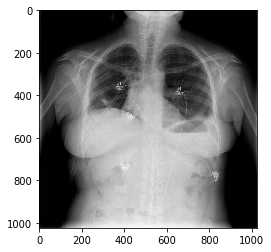

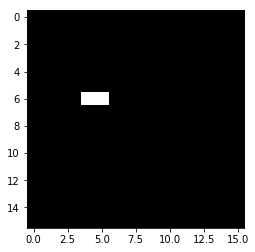

In [188]:
#check data generation
import random
X = np.array(X)
print('Shape of X: ',X.shape)
print('Shape of Output Y: ',np.array(Y_label_vectors).shape)

chp = random.choice(range(0,829))
plt.imshow(X[chp].reshape(1024,1024),cmap = 'gray')
plt.show()
plt.imshow(np.array(Y_label_vectors)[chp,:,:,0].reshape(16,16),cmap = 'gray')
plt.show()

In [189]:
X_test =[]
Y = np.zeros((1,16,16))
Y_backup = np.zeros((1,16,16))
Y_label_vectors_test=[]
classification_test=[]

#Randomizing the images
select_images_test = np.random.permutation(129)

N_img = 1

for i in select_images_test: #the random output index
    img_name = test_csv_output[i][0]
    xmin = float(test_csv_output[i][4])
    ymin = float(test_csv_output[i][5])
    xmax = float(test_csv_output[i][6])
    ymax = float(test_csv_output[i][7])
    disease_label = test_csv_output[i][3]
    
    #Loading the image
    img = scipy.misc.imread(os.path.join("test/",img_name))
    #print(img.shape)
    
    #Center of the nodule
    avg_x = (xmin+xmax)/2
    avg_y = (ymin+ymax)/2
    bx = avg_x
    by = avg_y
    
    #Bounding box dimensions 
    bh = ymax - ymin
    bw = xmax - xmin
    
    #Starting pixel values for 64x64 window sliding through the 1024 by 1024 image (16*16)
    nx = 0 
    ny = 0 
    #Moving horizontally through the original image
    
    for yaxis in range(0,16):
        #Starting sliding window from left side of the image 
        nx = 0 
        for xaxis in range(0,16): 
            
            #64 by 64 sub-image 
            window = img[ny:ny+64, nx:nx+64]
            #window starting and ending pixel coordinates 
            startx = nx
            starty = ny 
            endx = nx+63
            endy = ny+63

            #Checking if the center disease area is in the particular sub-image and recording the corresponding output pixel to be 1
            if startx >= (xmin-32) and endx <= (xmax+32) and starty >= (ymin-32) and endy <= (ymax+32):  
                #Setting output image pixel values 
                Y[0,yaxis,xaxis] = 1
            else: 
                Y[0,yaxis,xaxis] = 0
                
            if avg_x >= startx and avg_x <= endx and avg_y >= starty and avg_y <= endy:
                Y_backup[0,yaxis,xaxis] = 1
            else: 
                Y_backup[0,yaxis,xaxis] = 0
                
                
            #Moving horizontally
            nx = nx + 64
        #Moving Vertically
        ny = ny + 64
    #if no area in the bbox, use the area that at the center
    if np.array_equal(Y,np.zeros((1,16,16))):
        Y = Y_backup
    
    #Adding Y to the label vector 
    Y_label_vectors_test.append(np.transpose(Y,axes = [1,2,0]))
    
    #print(Y_label_vectors)
    classification_test.append(disease_label_dict[disease_label])
    
    #Adding 1024 by 1024 image to the X vector
    try:
        X_test.append(img.reshape(1024,1024,1))
    except:
        print(img_name)
        
    #Re-initializing Y for the next original image 
    Y = np.zeros((1,16,16))
    Y_backup = np.zeros((1,16,16))
    
    #Keeping track of number of images
    if N_img%100 == 0 : 
        print('Collected '+str(N_img) +' Images and labels')
        
    N_img+=1

/Users/yuxuan/Desktop/yolochestdicease/venv/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


Collected 100 Images and labels


Shape of X:  (129, 1024, 1024, 1)
Shape of Output Y:  (129, 16, 16, 1)


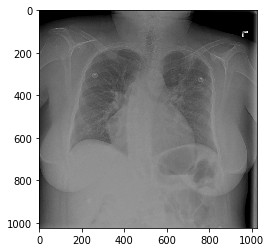

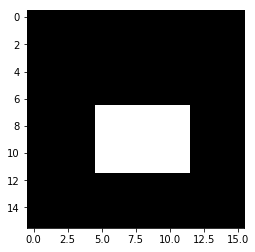

In [190]:
X_test = np.array(X_test)
print('Shape of X: ',X_test.shape)
print('Shape of Output Y: ',np.array(Y_label_vectors_test).shape)

chp = random.choice(range(0,150))
plt.imshow(X_test[chp].reshape(1024,1024),cmap = 'gray')
plt.show()
plt.imshow(np.array(Y_label_vectors_test)[chp,:,:,0].reshape(16,16),cmap = 'gray')
plt.show()

In [191]:
import keras.backend as K
K.clear_session()
input_shape = (1024,1024,1)

In [192]:
model = Sequential([
    Conv2D(32, (3, 3),strides = (1,1), input_shape=input_shape, padding='same',activation='relu'),
    BatchNormalization(axis = -1),
    
    Conv2D(32, (3, 3),strides = (1,1), padding='same',activation='relu'),
    BatchNormalization(axis = -1),
    MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None) ,
    
    Conv2D(32, (3, 3),strides = (1,1),padding='same',activation='relu'),
    BatchNormalization(axis = -1),
    MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None) ,   
    
    
    Conv2D(64, (3, 3),strides = (1,1), padding='same',activation='relu'),
    BatchNormalization(axis = -1),
    
    Conv2D(64, (3, 3),strides = (1,1), padding='same',activation='relu'),
    BatchNormalization(axis = -1),
    
    Conv2D(64, (3, 3),strides = (1,1),padding='same',activation='relu'),
    BatchNormalization(axis = -1),
    MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)  ,
    
    
    
    Conv2D(128, (3, 3),strides = (1,1),padding='same',activation='relu'),
    BatchNormalization(axis = -1),
    
    Conv2D(128, (3, 3),strides = (1,1),padding='same',activation='relu'),
    BatchNormalization(axis = -1),
    
    Conv2D(128, (3, 3),strides = (1,1), padding='same',activation='relu'),
    BatchNormalization(axis = -1),
    MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None) ,

    
    Conv2D(256, (3, 3),strides = (1,1),padding='same',activation='relu'),
    BatchNormalization(axis = -1),
     
    Conv2D(256, (3, 3),strides = (1,1),padding='same',activation='relu'),
    BatchNormalization(axis = -1),
     
    Conv2D(256, (3, 3),strides = (1,1),padding='same',activation='relu'),
    BatchNormalization(axis = -1),
    MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None) ,

    
    Conv2D(128, (3, 3),strides = (1,1),padding='same',activation='relu'),
    BatchNormalization(axis = -1),
    MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None) ,
    
    Conv2D(64, (3, 3),strides = (1,1),padding='same',activation='relu'),
    BatchNormalization(axis = -1),

    
    Conv2D(32, (3, 3),strides = (1,1),padding='same',activation='relu'),
    BatchNormalization(axis = -1),
    
    Conv2D(16, (3, 3),strides = (1,1),padding='same',activation='relu'),
    BatchNormalization(axis = -1),
    
    Conv2D(8, (3, 3),strides = (1,1),padding='same',activation='relu'),
    BatchNormalization(axis = -1),
    
    Conv2D(1, (3, 3),strides = (1,1),padding='same',activation='sigmoid',name = 'output'),
    
])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1024, 1024, 32)    320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024, 1024, 32)    128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1024, 1024, 32)    9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 1024, 1024, 32)    128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 512, 512, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 512, 512, 32)      9248      
_________________________________________________________________
batch_normalization_3 (Batch (None, 512, 512, 32)      128       
__________

In [193]:
#logistic loss - This loss function is designed purely for object detection. would explore more later
def loss_myconv_entire(y_true,y_pred):
    
    y_true_flat_layer0 = K.flatten(y_true[:,:,:,0])
    y_pred_flat_layer0 = K.flatten(y_pred[:,:,:,0])
    #Logistic loss for the probabilities 
    logistic_loss = K.sum(-y_true_flat_layer0*(K.log(y_pred_flat_layer0)) - (1-y_true_flat_layer0)*(K.log(1-y_pred_flat_layer0)))
    return logistic_loss

In [194]:
#call back function
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.loss = []
        self.val_acc =[]
        self.acc = []
        
    def on_batch_end(self, batch, logs={}):
        self.loss.append(logs.get('loss'))
        
    def on_epoch_end(self, epoch, logs):
        
        self.val_acc.append(logs.get('val_acc'))
        self.acc.append(logs.get('acc'))
    
    
# Create an instance of the history callback
history_cb = LossHistory()

In [196]:
#Complilation and fitting
opt= optimizers.Adam(lr = 0.001)
batch_size = 8
model.compile(loss=loss_myconv_entire, optimizer=opt)
print('Compiled')

model.fit(np.array(X), np.array(Y_label_vectors), batch_size=batch_size, epochs=2, verbose=1, validation_data=(np.array(X_test), np.array(Y_label_vectors_test)), callbacks = [history_cb])
print('Fitted')

Compiled
Train on 714 samples, validate on 129 samples
Epoch 1/2
714/714 [==============================] - 6145s 9s/step - loss: 998.9580 - val_loss: 667.9254
Epoch 2/2
714/714 [==============================] - 5645s 8s/step - loss: 544.4469 - val_loss: 443.1990
Fitted


In [203]:
#Save model weights
model.save_weights('my_model_weights.h5')

In [204]:
# Load model weights
model.load_weights('my_model_weights.h5')

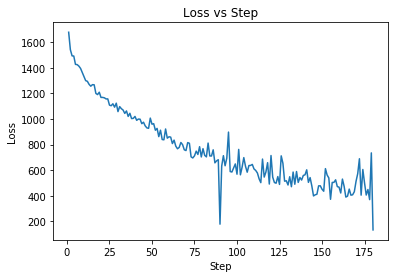

In [208]:
current_step = [i for i in range(1,len(history_cb.loss)+1)]
plt.plot(current_step,history_cb.loss)
# plt.semilogy(losses)
plt.ylabel('Loss')
plt.xlabel('Step')
plt.title('Loss vs Step')
plt.show()

In [214]:
current_step = [i for i in range(1,len(history_cb.loss)+1)]
plt.plot(current_step,history_cb.loss, label='Loss')
current_epochs = [i for i in range(1,len(history_cb.val_acc)+1)]
area2 = np.ma.masked_where(r >= r0, 20)
plt.scatter(90, 667.9254, s=area2, marker='o', 5)
plt.plot(180,443.1990, 'bo')
plt.show()

SyntaxError: positional argument follows keyword argument (<ipython-input-214-89a0de1a0fda>, line 5)

In [ ]:
#plot show

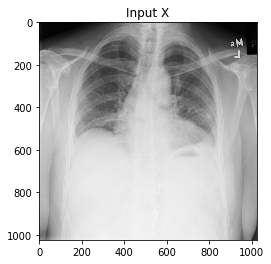

NameError: name 'Y_test' is not defined

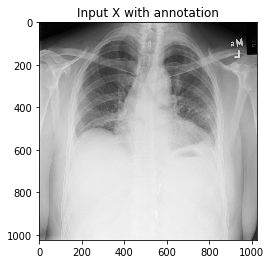

In [202]:

#choosing a random image
choice = 100

#predicting for the image with the trained model
yout = model.predict(X_test[choice:choice+1])

#Plotting input image
plt.imshow(X_test[choice:choice+1,:,:,0].reshape(1024,1024),cmap = 'gray')
plt.title('Input X')
plt.show()

#Plotting input image with annotated nodule
plt.imshow(X_test[choice:choice+1,:,:,0].reshape(1024,1024),cmap = 'gray')
plt.title('Input X with annotation')

#bounding box for annotation 
annot = np.where(Y_test[choice:choice+1,:,:,0]==1)
startx = annot[2][0]*32
endx = startx + 32
starty = annot[1][0]*32
endy = starty + 32

lines_x = []
lines_y = []

toph_x = [xx for xx in range(startx,endx+1)]
toph_y = [starty for new in toph_x]
lines_x.append(toph_x)
lines_y.append(toph_y)

bottomh_x = [xx for xx in range(startx,endx+1)]
bottomh_y = [endy for new in bottomh_x]
lines_x.append(bottomh_x)
lines_y.append(bottomh_y)

leftv_y = [yy for yy in range(starty,endy+1)]
leftv_x=[startx for new in leftv_y]
lines_x.append(leftv_x)
lines_y.append(leftv_y)

rightv_y = [yy for yy in range(starty,endy+1)]
rightv_x = [endx for new in rightv_y]
lines_x.append(rightv_x)
lines_y.append(rightv_y)

plt.plot(lines_x,lines_y,'go')

plt.show()

#Plotting Ground truth/Actual output
plt.imshow(Y_test[choice:choice+1,:,:,0].reshape(16,16),cmap = 'gray')
plt.title('Ground truth Output Y')
plt.show()

#Plotting predicted output
plt.imshow(yout[0,:,:,0].reshape(16,16),cmap = 'gray')
plt.title('Predicted Output Y: Heat Map')
plt.show()